# Initialization

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import pandas as pd

matplotlib.use('TkAgg')

# Interactive Hénon map

In [3]:
def henon_map(x, y, alpha=1.33):
    ''' henon_map function to update the points
    '''
    x_new = x * np.cos(alpha) - y * np.sin(alpha) + x ** 2 * np.sin(alpha)
    y_new = x * np.sin(alpha) + y * np.cos(alpha) - x ** 2 * np.cos(alpha)
    x_new = np.clip(x_new, -1e10, 1e10)   # For overflow problems
    y_new = np.clip(y_new, -1e10, 1e10)   # For overflow problems
    
    return x_new, y_new

  
def on_click(event):
    ''' on_click function to receive as input the click event
    '''
    x, y = event.xdata, event.ydata   # Receive the coordinates of the point clicked
    plt.plot(x, y, 'k')   # Plot the initial point
    for i in range(1000):
        x, y = henon_map(x, y, alpha)   # Updated to the next points in the map
        plt.plot(x, y, 'ko', markersize=0.1)   # Plot the next point
    plt.draw()

In [4]:
# Define the global parameter alpha ---------------------------------------------------------
alpha = 1.33

# Open a figure -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8,8))

# Setup the cursor widget -------------------------------------------------------------------
cursor = Cursor(ax, useblit=True, color='red', linewidth=0.1)

# Figure settings ---------------------------------------------------------------------------
plt.axhline(y=0, color='black', lw=0.5)
plt.axvline(x=0, color='black', lw=0.5)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.set_title(f'Hénon map with α={alpha:.2f}')
plt.connect('button_press_event', on_click)
plt.show()

One of the resulting images obtained is presented here for better consultation

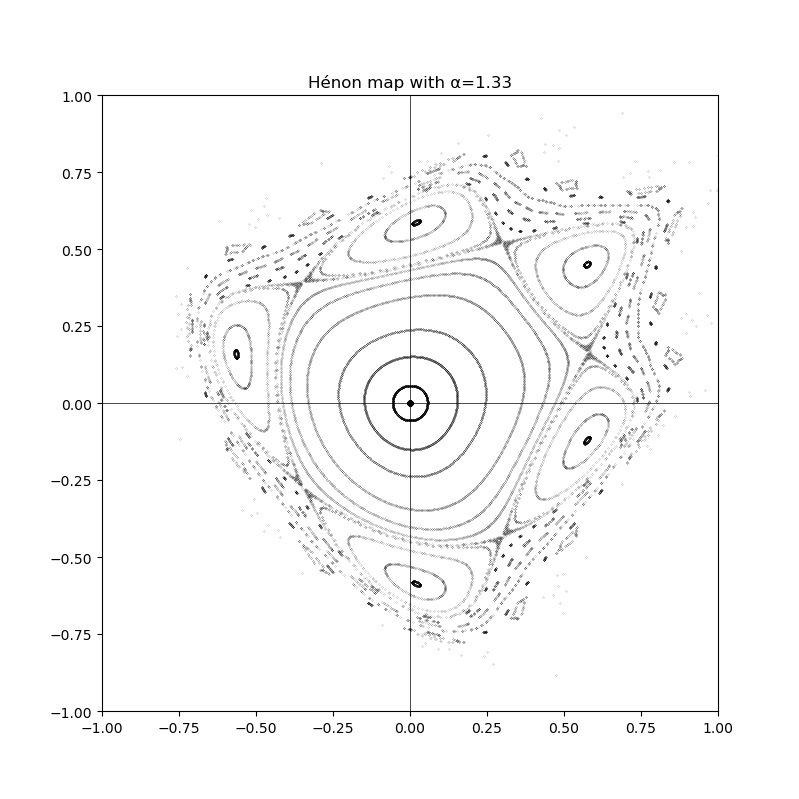

# 1. Show that this is an area-preserving map

To show that this henon map is an area-preserving map we need to show that the condition on the determinant of the Jacobian matrix of the map being equal to 1 holds. We can compute the Jacobian matrix $J(x,y)$ as
$$J(x,y)=\begin{bmatrix} \frac{\partial f_x}{\partial x} & \frac{\partial f_x}{\partial y} \\ \frac{\partial f_y}{\partial x} & \frac{\partial f_y}{\partial y} \end{bmatrix}=\begin{bmatrix} cos(\alpha)+2xsin(\alpha) & -sin(\alpha) \\ sin(\alpha)-2xcos(\alpha) & cos(\alpha) \end{bmatrix}$$
And we can compute its determinant as 
$$det(J)=cos(\alpha)[cos(\alpha)+2xsin(\alpha)] - (-sin(\alpha))[sin(\alpha)-2xcos(\alpha)]=cos^2(\alpha)+2xcos(\alpha)sin(\alpha)+sin^2(\alpha)-2xcos(\alpha)sin(\alpha)$$
$$det(J)=cos^2(\alpha)+sin^2(\alpha)=1, \; \forall x,y$$
So we obtain $det(J)=1, \; \forall x,y$ which is the condition that makes this henon map an area-preserving map

# 2. Compute the elliptic periodic orbit of period five mentioned before. Give all five points

We are interested in finnding the points which are fixed points for the 5th iterate of the henon map. Meaning that we are interested in points (x,y) such that 
$$(henon\_map \circ henon\_map \circ henon\_map \circ henon\_map \circ henon\_map) (x,y)=henon\_map\_5(x,y)=(x,y)$$ 
We will then apply a fixed point Newton method to find the points. We will do so to find the zero of the function
$$f(x,y)=henon\_map\_5(x,y)-(x,y)=0$$
To do so, we need to compute the Jacobian of such function. We can do so using the chain rule


In [5]:
# Redefine the henon_map function to use as input the coordinates in a vector x -------------
def henon_map(x, alpha=1.33):
    ''' henon_map function to update the points
    '''
    x_new = np.copy(x)   # This is needed because sometimes python applies to the point the transformation when used in a function
    x_new[0] = x[0] * np.cos(alpha) - x[1] * np.sin(alpha) + x[0] ** 2 * np.sin(alpha)
    x_new[1] = x[0] * np.sin(alpha) + x[1] * np.cos(alpha) - x[0] ** 2 * np.cos(alpha)
    x_new = np.clip(x_new, -1e10, 1e10)   # For overflow problems
    
    return x_new

# Define the function of which we want to find the zero -------------------------------------
def henon_map_5(x, alpha=1.33):
    ''' Function to apply the henon map 5 times 
    '''
    x_new = np.copy(x)   # This is needed because sometimes python applies to the point the transformation when used in a function
    for i in range(5):
        x_new = henon_map(x_new, alpha)
        
    return x_new

def f(x, alpha=1.33):
    ''' Function of which we want to find the zero
    '''
    x_new = np.copy(x)   # This is needed because sometimes python applies to the point the transformation when used in a function
    
    return henon_map_5(x_new, alpha)-x_new

# Define the function to compute the Jacobian -----------------------------------------------
def Jacobian(x, alpha=1.33):
    ''' Jacobian of the henon_map
    '''
    x_new = np.copy(x)   # This is needed because sometimes python applies to the point the transformation when used in a function

    return [[np.cos(alpha) + 2*x_new[0]*np.sin(alpha), -np.sin(alpha)], 
            [np.sin(alpha) - 2*x_new[0]*np.cos(alpha), np.cos(alpha)]]

def Jacobian_5(x, alpha=1.33):
    ''' Jacobian of the 5th iterate of the henon map
    '''
    x_new = np.copy(x)   # This is needed because sometimes python applies to the point the transformation when used in a function
    J = np.eye(2)
    for i in range(5):
        Jx = Jacobian(x_new, alpha)
        J = np.dot(Jx,J)
        x_new = henon_map(x_new, alpha)
        
    return J

def Jacobian_f(x, alpha=1.33):
    ''' Jacobian of the function of which we want to find the zero
    '''
    x_new = np.copy(x)   # This is needed because sometimes python applies to the point the transformation when used in a function
    
    return Jacobian_5(x_new, alpha) - np.eye(2)

We can now use a fixed point Newton method in order to compute the period five points

In [6]:
def Newton_method(x0, alpha=1.33, max_iter=1000, tol=1e-12):
    x_1 = x0
    for i in range(max_iter):
        x_2 = x_1 - np.dot(np.linalg.inv(Jacobian_f(x_1, alpha)),f(x_1, alpha))       # Here computing the inverse using this function is not computationally optimal,
        if np.linalg.norm(x_2-x_1) < tol:                                                    # and in this case it could be done by hand. But, since it is not exactly the object
            print("The method converged to the solution: (", x_2[0], ",", x_2[1], ")")   #  of this exercise, we can use it, as it is conceptually equivalent
            print("The method converged in", i, "iterations")
            return x_2   # Found a fixed point
        x_1 = x_2 
    
    print("The fixed point Newton method did not converge to a solution")
    return [np.nan, np.nan]

# Apply the fixed point Newton method using an ititial guess from the plotted map -----------
x0 = np.array([0.57, 0.45])   # Initial guess
x_periodic = Newton_method(x0)

The method converged to the solution: ( 0.5747468158977505 , 0.450686500095705 )
The method converged in 3 iterations


In [7]:
# Iterate the map 5 times to get the other points in the orbit ------------------------------
def compute_periodic_orbit(x_periodic, period, alpha=1.33):
    x = x_periodic
    periodic_orbit = [x_periodic]
    for i in range(period-1):
        x = henon_map(x, alpha)
        periodic_orbit.append(x)

    print("The points in the elliptic periodic orbit of period 5 are the following: ")
    for point in periodic_orbit:
        print(point)
        
    return periodic_orbit

elliptic_periodic_orbit = compute_periodic_orbit(x_periodic, period=5)

The points in the elliptic periodic orbit of period 5 are the following: 
[0.57474682 0.4506865 ]
[0.02018312 0.58686565]
[-0.56472483  0.15945707]
[ 0.02018312 -0.58645829]
[ 0.57474682 -0.1203526 ]


In the following we visualize the results more clearly

In [13]:
d = {'x': np.asarray(elliptic_periodic_orbit)[:,0], 'y':np.asarray(elliptic_periodic_orbit)[:,1]}
df = pd.DataFrame(data=d) 
df

,x,y
0,0.574747,0.450687
1,0.020183,0.586866
2,-0.564725,0.159457
3,0.020183,-0.586458
4,0.574747,-0.120353


# 3. Compute the hyperbolic periodic orbit of period five mentioned before. Give all five points

In order to do so, we can use a similar strategy to the one we used in part 2. In this case we need to change the initial seed used for the Newton method and use a point close to the ones we are looking for.

In [15]:
# Apply the fixed point Newton method using an ititial guess from the plotted map -----------
x0 = np.array([0.25, 0.50])   # Initial guess
x_periodic = Newton_method(x0)

The method converged to the solution: ( 0.2986362229451406 , 0.5200010273530175 )
The method converged in 4 iterations


In [16]:
# Iterate the map 5 times to get the other points in the orbit ------------------------------
hyperbolic_periodic_orbit = compute_periodic_orbit(x_periodic, period=5)

The points in the elliptic periodic orbit of period 5 are the following: 
[0.29863622 0.52000103]
[-0.34717006  0.39275972]
[-0.34717006 -0.27223267]
[ 0.29863622 -0.43081743]
[0.57621574 0.16601229]


In the following we visualize the results more clearly

In [17]:
d = {'x': np.asarray(hyperbolic_periodic_orbit)[:,0], 'y':np.asarray(hyperbolic_periodic_orbit)[:,1]}
df = pd.DataFrame(data=d) 
df

,x,y
0,0.298636,0.520001
1,-0.347170,0.392760
2,-0.347170,-0.272233
3,0.298636,-0.430817
4,0.576216,0.166012


# 4. Compute the eigenvalues related to the elliptic and the hyperbolic periodic orbit. Do they depend on the starting point of the orbit? What can you tell about their product?


**Elliptic orbit**

In [19]:
eigvals = []
eigvals_norm = []
determinant = []
print("--------------------------------------------------------------------------")
print("The eigenvalues of the Jacobian in the points of the elliptic orbit is:")
for i in range(5):
    eigvals.append(np.linalg.eigvals(Jacobian_5(elliptic_periodic_orbit[i])))
    print(eigvals[i])
    eigvals_norm.append(abs(np.linalg.eigvals(Jacobian_5(elliptic_periodic_orbit[i]))))
    print(eigvals_norm[i])
print("--------------------------------------------------------------------------")
print("The determinant of the Jacobian in the points of the elliptic orbit is:")
for i in range(5):
    determinant.append(np.linalg.det(Jacobian_5(elliptic_periodic_orbit[i])))
    print(determinant[i])
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
The eigenvalues of the Jacobian in the points of the elliptic orbit is:
[0.87195335+0.48958896j 0.87195335-0.48958896j]
[1. 1.]
[0.87195335+0.48958896j 0.87195335-0.48958896j]
[1. 1.]
[0.87195335+0.48958896j 0.87195335-0.48958896j]
[1. 1.]
[0.87195335+0.48958896j 0.87195335-0.48958896j]
[1. 1.]
[0.87195335+0.48958896j 0.87195335-0.48958896j]
[1. 1.]
--------------------------------------------------------------------------
The determinant of the Jacobian in the points of the elliptic orbit is:
1.0
0.9999999999999993
0.9999999999999996
1.0
0.9999999999999998
--------------------------------------------------------------------------


Let's visualize the results more clearly

In [22]:
d = {'x': np.asarray(hyperbolic_periodic_orbit)[:,0], 'y':np.asarray(hyperbolic_periodic_orbit)[:,1],
    'lambda_1': np.asarray(eigvals)[:,0], 'lambda_2': np.asarray(eigvals)[:,1], 
    '|lambda_1|': np.asarray(eigvals_norm)[:,0], '|lambda_2|': np.asarray(eigvals_norm)[:,1],
    'Det(J_5)': determinant}
df = pd.DataFrame(data=d) 
df

,x,y,lambda_1,lambda_2,|lambda_1|,|lambda_2|,Det(J_5)
0,0.298636,0.520001,0.871953+0.489589j,0.871953-0.489589j,1.0,1.0,1.0
1,-0.347170,0.392760,0.871953+0.489589j,0.871953-0.489589j,1.0,1.0,1.0
2,-0.347170,-0.272233,0.871953+0.489589j,0.871953-0.489589j,1.0,1.0,1.0
3,0.298636,-0.430817,0.871953+0.489589j,0.871953-0.489589j,1.0,1.0,1.0
4,0.576216,0.166012,0.871953+0.489589j,0.871953-0.489589j,1.0,1.0,1.0


We can observe that the product of the eigenvalues of the Jacobian in each point of the matrix, which is equal to the determinant, is equal to one. This is due to the fact that these points in this orbit act as centers of elliptic orbits around them.

**Hyperbolic orbit**

In [23]:
eigvals = []
eigvals_norm = []
determinant = []
print("--------------------------------------------------------------------------")
print("The eigenvalues of the Jacobian in the points of the hyperbolic orbit is:")
for i in range(5):
    eigvals.append(np.linalg.eigvals(Jacobian_5(hyperbolic_periodic_orbit[i])))
    print(eigvals[i])
    eigvals_norm.append(abs(np.linalg.eigvals(Jacobian_5(hyperbolic_periodic_orbit[i]))))
    print(eigvals_norm[i])
print("--------------------------------------------------------------------------")
print("The determinant of the Jacobian in the points of the hyperbolic orbit is:")
for i in range(5):
    determinant.append(np.linalg.det(Jacobian_5(hyperbolic_periodic_orbit[i])))
    print(determinant[i])
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
The eigenvalues of the Jacobian in the points of the hyperbolic orbit is:
[1.53278088 0.65240898]
[1.53278088 0.65240898]
[0.65240898 1.53278088]
[0.65240898 1.53278088]
[1.53278088 0.65240898]
[1.53278088 0.65240898]
[0.65240898 1.53278088]
[0.65240898 1.53278088]
[1.53278088 0.65240898]
[1.53278088 0.65240898]
--------------------------------------------------------------------------
The determinant of the Jacobian in the points of the hyperbolic orbit is:
1.0000000000000004
1.0
1.0
1.0000000000000002
1.0000000000000004
--------------------------------------------------------------------------


Let's visualize the results more clearly

In [24]:
d = {'x': np.asarray(hyperbolic_periodic_orbit)[:,0], 'y':np.asarray(hyperbolic_periodic_orbit)[:,1],
    'lambda_1': np.asarray(eigvals)[:,0], 'lambda_2': np.asarray(eigvals)[:,1], 
    '|lambda_1|': np.asarray(eigvals_norm)[:,0], '|lambda_2|': np.asarray(eigvals_norm)[:,1],
    'Det(J_5)': determinant}
df = pd.DataFrame(data=d) 
df

,x,y,lambda_1,lambda_2,|lambda_1|,|lambda_2|,Det(J_5)
0,0.298636,0.520001,1.532781,0.652409,1.532781,0.652409,1.0
1,-0.347170,0.392760,0.652409,1.532781,0.652409,1.532781,1.0
2,-0.347170,-0.272233,1.532781,0.652409,1.532781,0.652409,1.0
3,0.298636,-0.430817,0.652409,1.532781,0.652409,1.532781,1.0
4,0.576216,0.166012,1.532781,0.652409,1.532781,0.652409,1.0


We can observe that each of the point in the hyperbolic orbit of period five has one eigenvalue with absolute value larger than one and the other with absolute value smaller than one. Their product, which is equal to the determinant of the Jacobian is still 1, but the behaviour of these points is the one of a saddle point.